In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    @property
    def backward(self):
        return self._backward

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    def get_data(self):
        return self._data

    def set_data(self, data):
        if not isinstance(data, (int, float)):
            raise TypeError("Temperature must be a number.")
        self._data = data

    data = property(get_data, set_data)

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def draw_dot(root):
    def trace(root):
        # builds a set of all nodes and edges in the graph
        nodes, edges = set(), set()
        def build(v):
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
        build(root)
        return nodes, edges
    
    dot = Digraph(format='svg',graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operataion, create an op node for it
            name = uid + n.op
            dot.node(name = name, label = n.op)
            dot.edge(name, uid)
    for e1, e2 in edges:
        # connect e1 to the op node of e1
        dot.edge(str(id(e1)), str(id(e2)) + e2.op)
    return dot

In [4]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    actication = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = actication.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

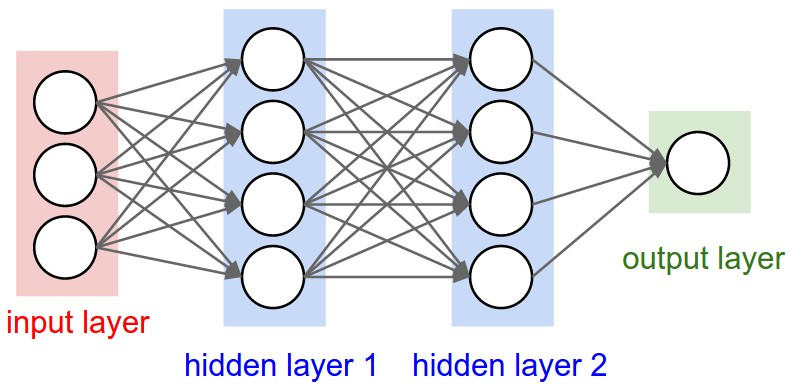

In [16]:
# input layer of 3 neurons
input_layer = [2.0, 3.0, -1.0]
n = Neuron(3)
# MLP with 3 input neurons and 3 layers of 4 neurons, 4 neurons and single output neuron
mlp = MLP(len(input_layer), [4, 4, 1])
output_layer = mlp(input_layer)
print(output_layer)

Value(data=-0.8177237019384578, label=, grad=0.0)


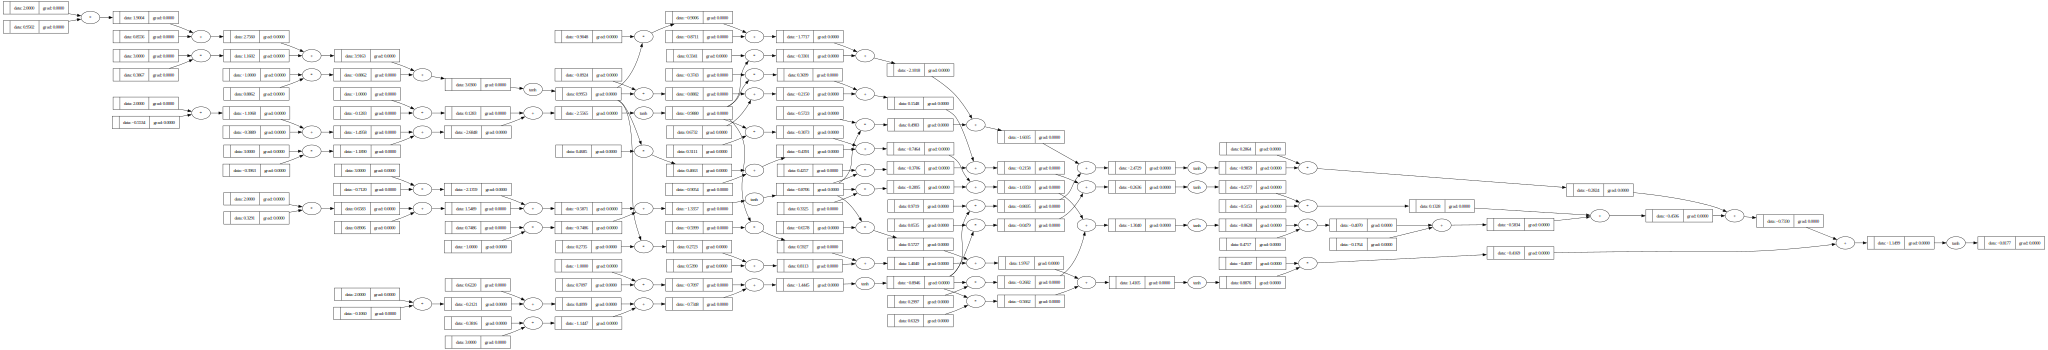

In [17]:
draw_dot(output_layer)

In [18]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [mlp(x) for x in xs]
ypred
# the values of the output of the NN.
# first value is -0.81 and we want it to be 1.0, so we need to push it higher
# second value is -0.83 and we want it to be -1.0, so we need to push it lower
# second value is -0.82 and we want it to be -1.0, so we need to push it lower
# second value is -0.84 and we want it to be 1.0, so we need to push it highrt

[Value(data=-0.8177237019384578, label=, grad=0.0),
 Value(data=-0.8326836951722209, label=, grad=0.0),
 Value(data=-0.8263407564676033, label=, grad=0.0),
 Value(data=-0.8446618495061908, label=, grad=0.0)]

In [19]:
# we need a loss to tune the weights to better predict the desired targets
# loss is a single number that measures how well the NN is performing
# we'll calculate the MSRE
loss_values = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss_values

[Value(data=3.304119456588851, label=, grad=0.0),
 Value(data=0.027994745861222314, label=, grad=0.0),
 Value(data=0.030157532864244264, label=, grad=0.0),
 Value(data=3.4027773390236007, label=, grad=0.0)]

In [20]:
loss = sum(loss_values)
loss

Value(data=6.765049074337918, label=, grad=0.0)

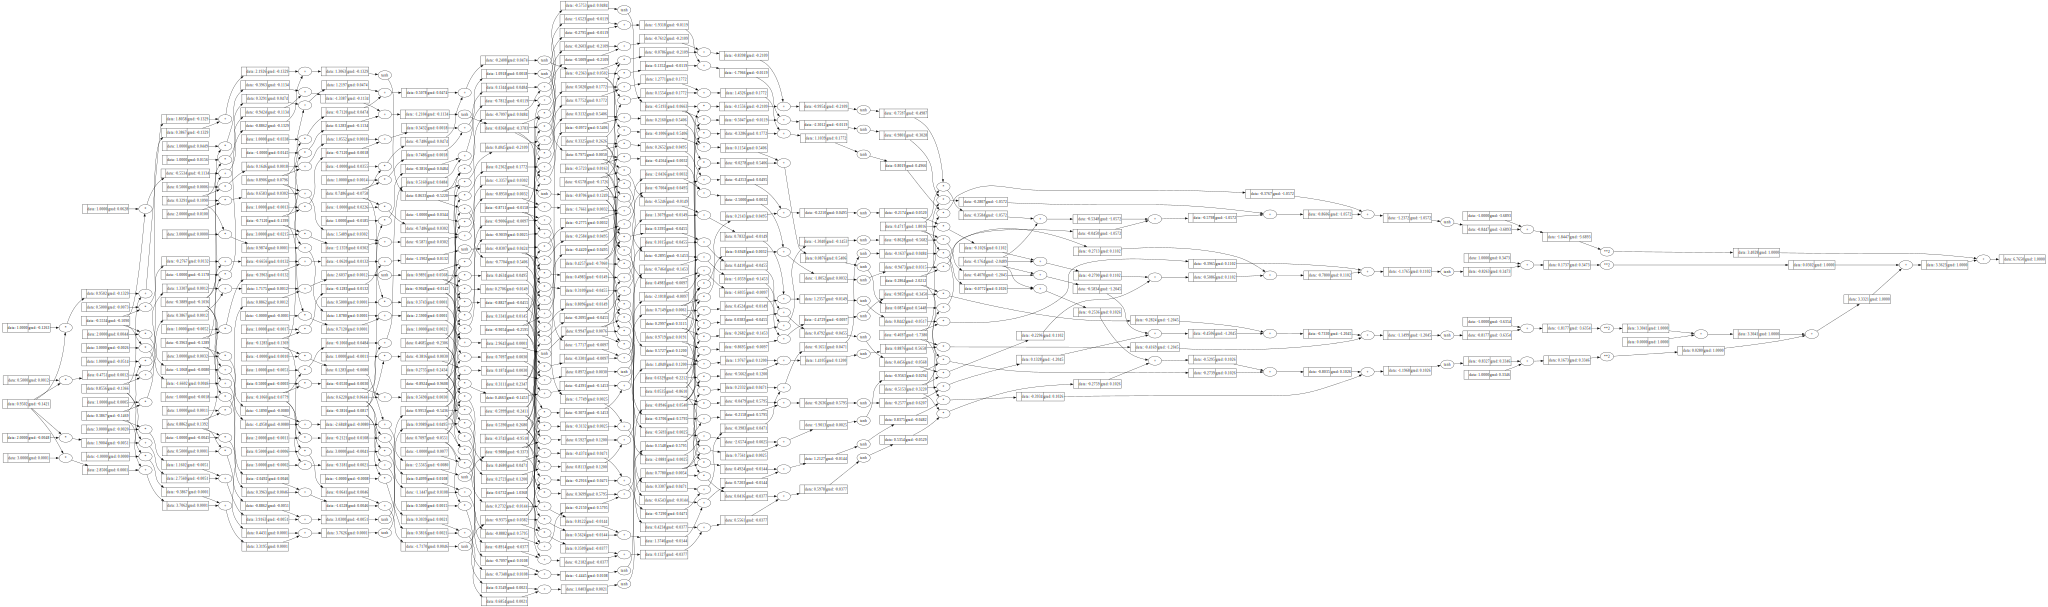

In [22]:
loss.backward()
draw_dot(loss)

In [23]:
mlp.layers[0].neurons[0].w[0].grad

-0.14207838137491635

In [24]:
mlp.layers[0].neurons[0].w[0].data

0.9501845115832641

In [25]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [26]:
mlp.layers[0].neurons[0].w[0].data

0.9516052953970133

In [27]:
# let's recalculate the loss
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.555872519601166, label=, grad=0.0)

In [78]:
loss.backward()

In [79]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad
mlp.layers[0].neurons[0].w[0].data

1.0806628799388296

In [80]:
# let's recalculate the loss
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.003585510267455895, label=, grad=0.0)

In [81]:
# repeat until loss is minimized
# basically perform gradient decent using forward pass, backward pass and update
# and the NN will improve it's predition
ypred

[Value(data=0.97121968723956, label=, grad=0.0),
 Value(data=-0.9878070330260097, label=, grad=0.0),
 Value(data=-0.986873307809841, label=, grad=0.0),
 Value(data=0.9506418661882041, label=, grad=0.0)]

In [82]:
mlp.parameters()

[Value(data=1.0806628799388296, label=, grad=-1.1189391693983086),
 Value(data=0.5183765318422162, label=, grad=-1.1161874349646288),
 Value(data=0.737595013563946, label=, grad=1.3633766297362315),
 Value(data=0.978013804443695, label=, grad=-1.0308864742480501),
 Value(data=-0.509527882121239, label=, grad=-0.26578204285118695),
 Value(data=-0.31170820361545964, label=, grad=-0.6619314836576232),
 Value(data=-0.28014986313275747, label=, grad=1.4165219851471913),
 Value(data=-0.34454562182458826, label=, grad=-0.27073832747046933),
 Value(data=0.25782563003753217, label=, grad=0.18607599004752626),
 Value(data=-0.7471237396370993, label=, grad=-0.5068360106437678),
 Value(data=1.036723406995644, label=, grad=-3.5449890065099736),
 Value(data=0.9130904861440324, label=, grad=-1.0482281634943025),
 Value(data=0.07844715356971498, label=, grad=-3.234084480881443),
 Value(data=-0.44073588134394237, label=, grad=0.2017880048815383),
 Value(data=0.9529711426554401, label=, grad=-3.18321498

In [91]:
## lets combine everything
# mlp
# input layer of 3 neurons
input_layer = [2.0, 3.0, -1.0]
n = Neuron(3)
# MLP with 3 input neurons and 3 layers of 4 neurons, 4 neurons and single output neuron
mlp = MLP(len(input_layer), [4, 4, 1])
# data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# targets
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# "train" the model
for i in range(100):
    # forward pass
    ypred = [mlp(x) for x in xs]
    # initialize the loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    # reset grads before backward pass
    # https://x.com/karpathy/status/1013244313327681536?lang=en
    for p in mlp.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # update using Gradient Descent
    for p in mlp.parameters():
        p.data += -0.01 * p.grad
    print(i, loss.data)

0 3.8086260555052
1 3.2304365748724306
2 2.8648300231287767
3 2.579124791877414
4 2.331939648250701
5 2.1102551582202196
6 1.9088684265770546
7 1.7253122019871339
8 1.5582770175326024
9 1.4069268392815344
10 1.2705314731920492
11 1.14828107653038
12 1.0392271166471199
13 0.9423008393183363
14 0.8563663436267706
15 0.7802787282216066
16 0.7129320232876499
17 0.6532920149672092
18 0.6004147983011514
19 0.5534541724011914
20 0.5116613241092554
21 0.4743797313824144
22 0.44103747351002076
23 0.41113844357983126
24 0.38425341330047647
25 0.3600115080274336
26 0.33809238495973015
27 0.31821923778116895
28 0.30015264796600005
29 0.28368524444321785
30 0.2686371034017
31 0.25485180779665073
32 0.24219308434658507
33 0.2305419398318248
34 0.2197942254094623
35 0.20985856568587924
36 0.20065459741669975
37 0.19211147038210694
38 0.18416656994557787
39 0.176764426949434
40 0.16985578593138448
41 0.16339680721428307
42 0.15734838230248369
43 0.15167554529613297
44 0.1463469657919429
45 0.141334511

In [87]:
# expect ypred to be very accurate
ypred

[Value(data=0.9999741985067049, label=, grad=-5.1602986590237876e-05),
 Value(data=-1.0, label=, grad=0.0),
 Value(data=-1.0, label=, grad=0.0),
 Value(data=0.9999766258625724, label=, grad=-4.674827485517952e-05)]